# Redes LSTM

Las redes Long Short Term Memory (LSTM) son redes neuronales recurrentes utilizadas para capturar dependencias de datos a largo plazo. Para ello, en sus unidades mínimas de procesamiento llamadas *celdas de memoria* emplean las puertas *forget*, *input* y *output*. La puerta *forget* controla la cantidad de información que se debe descartar o, lo que es lo mismo, cuánta información se debe recordar. Por ello, en ciertos textos son denotadas también puertas *keep*. Por su parte, la puerta *input* controla cómo ha de actualizarse la información en la celda de memoria. Finalmente, la puerta *output* controla la información de salida y la que se transmitirá al siguiente paso de la secuencia al tratarse de una red recurrente.

Comencemos por importar las librería para poder, en última instancia, construir el modelo:

In [27]:
# !pip install tensorflow
import tensorflow 
from tensorflow import keras

print('Versión tensorflow:', tensorflow.__version__)
print('Versión keras:', keras.__version__)

Versión tensorflow: 2.12.0
Versión keras: 2.12.0


Importamos el dataset que contiene la información de los precios del Bitcoin (BTC):

In [3]:
import pandas as pd

df = pd.read_csv('btc.csv')

df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [4]:
df = df[['Date', 'Closing Price (USD)']]

df.head()

,Date,Closing Price (USD)
0,2013-10-01,123.65499
1,2013-10-02,125.45500
2,2013-10-03,108.58483
3,2013-10-04,118.67466
4,2013-10-05,121.33866


In [5]:
df.tail()

,Date,Closing Price (USD)
2608,2020-12-31,29111.52157
2609,2021-01-01,29333.60512
2610,2021-01-02,32154.16736
2611,2021-01-03,33002.53643
2612,2021-01-04,31431.61228


Detectamos que las cuatro últimas fechas no se encuentran dentro de nuestra ventana de trabajo (desde $2013$ hasta finales de $2020$), luego las eliminamos sin problema:

In [6]:
df.drop(df.tail(4).index,inplace = True)

df.tail()

,Date,Closing Price (USD)
2604,2020-12-27,26389.29026
2605,2020-12-28,26718.02946
2606,2020-12-29,26975.72956
2607,2020-12-30,28768.83621
2608,2020-12-31,29111.52157


Tras quedarnos con las variables necesarias para construir el modelo, determinamos si existen *missings* en alguna de las columnas y el tipo de cada una de las variables:

In [20]:
df.isnull().sum()

Date                   0
Closing Price (USD)    0
dtype: int64

In [9]:
df.dtypes

Date                    object
Closing Price (USD)    float64
dtype: object

In [10]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [11]:
df.dtypes

Date                   datetime64[ns]
Closing Price (USD)           float64
dtype: object

Una vez tenemos el dataset inicial con esta información y formato, lo dividimos en los conjuntos de *train* y de *test*:

In [12]:
train_completo =  pd.DataFrame(df[df['Date'] < pd.to_datetime('2020-06-01')])
test_completo =  pd.DataFrame(df[df['Date'] >= pd.to_datetime('2020-06-01')])

In [15]:
train = pd.DataFrame(train_completo['Closing Price (USD)'])
test = pd.DataFrame(test_completo['Closing Price (USD)'])

Puesto que nos encontramos ante un problema de *forecasting*, reescalamos los datos para que todas los precios se encuentren entre $0$ y $1$ empleando *MinMaxScaler* de la librería *sklearn*. De este modo, aumentaremos el poder predictivo del modelo:

In [17]:
from sklearn.preprocessing import MinMaxScaler

minmaxSc = MinMaxScaler()
sc_train = minmaxSc.fit_transform(train)
sc_test =  minmaxSc.transform(test)

Nótese que hemos creado el transformador *MinMaxScaler* empleando únicamente datos del dataset llamado *train*, ya que en el proceso de transformación no puede intervenir información procedente del dataset llamado *test*. A continuación, procedemos a estructurar el dataset de *train* en función de los días que queramos tener en cuenta para realizar la predicción del día siguiente. En este caso, tendremos en cuenta los 30 días anteriores:

In [18]:
import numpy as np

windows = 30
X_train = []
Y_train = []

for i in range(windows, sc_train.size):
    
    X_train.append(sc_train[i-windows:i,0])
    Y_train.append(sc_train[i,0])

# Tras la creacion de las listas X_train, Y_train para entrenar el modelo, redimensionamos los conjuntos para aplicar directamente el modelo
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Veamos el primer elemento del conjunto X_train
X_train[0]

array([[0.00079074],
       [0.00088518],
       [0.        ],
       [0.00052942],
       [0.0006692 ],
       [0.00063334],
       [0.00069314],
       [0.0007581 ],
       [0.00081141],
       [0.00091174],
       [0.00087598],
       [0.00090998],
       [0.00093389],
       [0.00139871],
       [0.00129174],
       [0.00179336],
       [0.0015394 ],
       [0.00180324],
       [0.00230696],
       [0.00271555],
       [0.00292418],
       [0.003623  ],
       [0.00418253],
       [0.0048334 ],
       [0.0037658 ],
       [0.00348649],
       [0.00362631],
       [0.00412286],
       [0.00441652],
       [0.00466016]])

Comprobemos las dimensiones del conjunto X_train:

In [21]:
X_train.shape

(2365, 30, 1)

Una vez hemos terminado con los preparativos, podemos comenzar a crear nuestra red LSTM. Construiremos una red con una capa LSTM con 60 unidades de memoria. Finalmente, hemos configurado una capa de salida con una única neurona:

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

modelo = Sequential()
modelo.add(LSTM(units=60, input_shape=(X_train.shape[1],1)))
modelo.add(Dense(1))

Con la estructura de la red definida, solo falta definir la función de pérdida que utilizará para aprender los pesos de la red y el método de optimización de la función de pérdida. La función de pérdida será el llamado *Mean Square Error* y el método escogido el *adam*:

In [23]:
modelo.compile(optimizer='adam', loss='mse')

Finalmente, entrenamos el modelo estableciendo previamente un número de *epochs* y un tamaño de *batch*. Estas variables, al igual que las anteriores y la propia estructura de la red, son hiperparámetros del modelo que podrían ajustarse para tratar de obtener el máximo rendimiento del modelo. Sin embargo, en este caso, nosotros fijaremos un valor determinado:

In [24]:
modelo.fit(X_train,Y_train,epochs=10,batch_size=20)

Epoch 1/10
119/119 [==============================] - 2s 8ms/step - loss: 0.0028
Epoch 2/10
119/119 [==============================] - 1s 8ms/step - loss: 6.5357e-04
Epoch 3/10
119/119 [==============================] - 1s 7ms/step - loss: 6.1143e-04
Epoch 4/10
119/119 [==============================] - 1s 8ms/step - loss: 4.9540e-04
Epoch 5/10
119/119 [==============================] - 1s 7ms/step - loss: 4.3841e-04
Epoch 6/10
119/119 [==============================] - 1s 8ms/step - loss: 4.3851e-04
Epoch 7/10
119/119 [==============================] - 1s 7ms/step - loss: 3.8146e-04
Epoch 8/10
119/119 [==============================] - 1s 7ms/step - loss: 3.9739e-04
Epoch 9/10
119/119 [==============================] - 1s 7ms/step - loss: 3.7104e-04
Epoch 10/10
119/119 [==============================] - 1s 7ms/step - loss: 3.5756e-04


Una vez entrenado, podemos medir el rendimiento del modelo con el conjunto de *test*:

In [28]:
X_test = []
Y_test = []

for i in range(windows, sc_test.size):
    X_test.append(sc_test[i-windows:i,0])
    Y_test.append(sc_test[i,0])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Veamos el primer elemento del conjunto X_test
X_test[0]

array([[0.48897537],
       [0.53309829],
       [0.49361718],
       [0.50153628],
       [0.50910808],
       [0.50114803],
       [0.50206047],
       [0.50523007],
       [0.5080881 ],
       [0.50778451],
       [0.51244519],
       [0.48022136],
       [0.49089358],
       [0.49060141],
       [0.48500251],
       [0.48971515],
       [0.49332991],
       [0.49054722],
       [0.48745226],
       [0.48121452],
       [0.48506151],
       [0.48170479],
       [0.5022649 ],
       [0.4985255 ],
       [0.48286081],
       [0.47979114],
       [0.47554622],
       [0.4676978 ],
       [0.47187949],
       [0.47640303]])

In [29]:
from sklearn.metrics import mean_squared_error

y_pred = modelo.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)

print("Error Cuadrático Medio (MSE):", mse)

6/6 [==============================] - 0s 4ms/step
Error Cuadrático Medio (MSE): 0.0014928338476201675


Como podemos observar tras medir el rendimiento con el conjunto de test, el modelo que hemos creado tiene un MSE de $0.0015$. Nótese que hemos redimensionado los datos para que todos estuvieran en el rango de valores $[0,1]$, luego el MSE también se encontrará afectado por esta transformación. Aun así, un error cuadrático medio de $0.0015$ en este caso parece un error aceptable teniendo en cuenta que no hemos realizado ningún tipo de ajuste de hiperparámetros.

Veamos una representación gráfica de las predicciones con los valores de la serie temporal del conjunto de test:

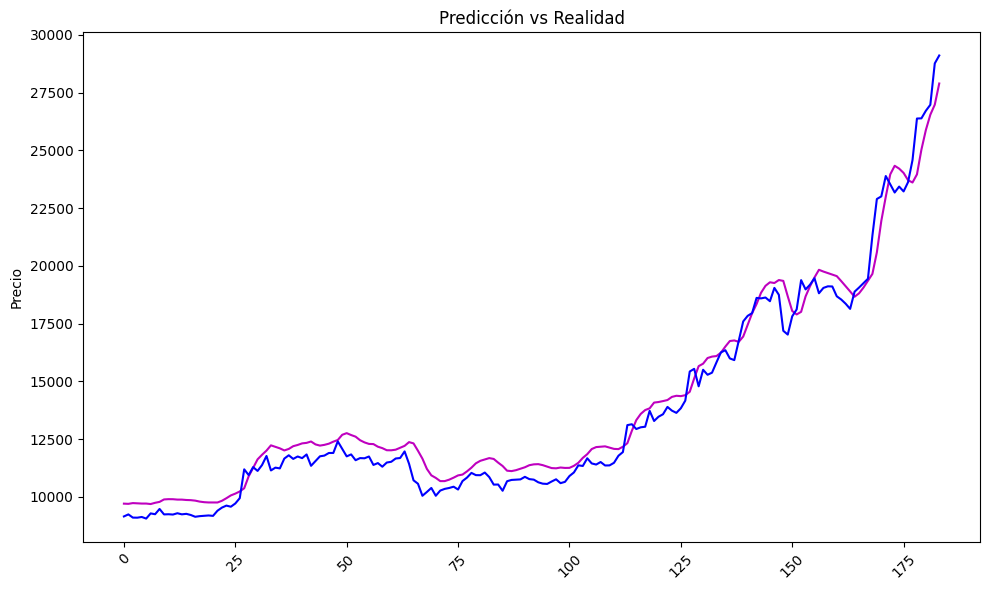

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(minmaxSc.inverse_transform(y_pred), label='Predicciones', color='m')
plt.plot(minmaxSc.inverse_transform(pd.DataFrame(Y_test)), label='Valores reales', color='b')
plt.title('Predicción vs Realidad')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()